# EDA and Models for Sentiment Analysis

In this notebook we will do some data analysis with the sentiment dataset we put together.
Furthermore we will use some machine learning models to try and classify the data.

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys

# Add custom functions path
sys.path.append('../Functions')

In [2]:
# Import data with custom function so the classes are balanced
from datasets import load_stratified_dataset
df = load_stratified_dataset(path='../Datasets/full_good_bad_dataset.csv', labels='label', samples_per_label=2854)

# Did it work?
df.label.value_counts()

1    2854
0    2853
Name: label, dtype: int64

## EDA
We start by doing some analysis of our data.

***
- label: 1 = good sentiment; 0 = bad or neutral sentiment
- source: the website the articles were scraped from
- text: the complete article text
- title: the news headline
- url: the original link to the article
- text_lem: preprocessed text without stopwords etc.
***

In [3]:
df.head()

,label,source,text,title,url,text_lem
0,0,JustBadNews,"In a Saturday statement, Secretary of State Mi...",Mike Pompeo accused a veteran NPR reporter of ...,businessinsider,saturday statement secretary state mike pompeo...
1,1,webhose.io,"0 comments Tom Newcombe Thu, 16 Jul 2015 11:09...",Chambers Events reports 70% turnover growth,NaN,0 comment tom newcombe thu 16 jul 2015 11:09 f...
2,1,webhose.io,10 Best Biotech Stocks in the NASDAQ Written b...,10 Best Biotech Stocks in the NASDAQ,NaN,10 good biotech stock nasdaq write jon kostako...
3,1,good_news_network,"""A Muslim man jumped to the aid of three Jewis...",Muslim Helps Jews Attacked on New York Subway ...,goodnewsnetwork,muslim man jump aid jewish subway rider attack...
4,0,CollapseNews,A sitting U.S. president who can’t stop attack...,Surely these are the end times: GOP demands em...,vanityfair,sit u.s president stop attack black brown peop...


In [4]:
import tldextract

url_lst = []

for url in df.url.values:
    try:
        info = tldextract.extract(url)
        url_lst.append(info.domain)
    except:
        url_lst.append(None)

df['url'] = url_lst

In [5]:
# Overview
df.head()

,label,source,text,title,url,text_lem
0,0,JustBadNews,"In a Saturday statement, Secretary of State Mi...",Mike Pompeo accused a veteran NPR reporter of ...,businessinsider,saturday statement secretary state mike pompeo...
1,1,webhose.io,"0 comments Tom Newcombe Thu, 16 Jul 2015 11:09...",Chambers Events reports 70% turnover growth,None,0 comment tom newcombe thu 16 jul 2015 11:09 f...
2,1,webhose.io,10 Best Biotech Stocks in the NASDAQ Written b...,10 Best Biotech Stocks in the NASDAQ,None,10 good biotech stock nasdaq write jon kostako...
3,1,good_news_network,"""A Muslim man jumped to the aid of three Jewis...",Muslim Helps Jews Attacked on New York Subway ...,goodnewsnetwork,muslim man jump aid jewish subway rider attack...
4,0,CollapseNews,A sitting U.S. president who can’t stop attack...,Surely these are the end times: GOP demands em...,vanityfair,sit u.s president stop attack black brown peop...


***
#### Domains
Let's first look at the different domains we have in this dataset.
***

In [6]:
# Count unknown article source and drop those
url_list = df.url
print(f'The url is unknown for {df.url.isnull().sum()} articles')
url_list = url_list.dropna();

The url is unknown for 2305 articles


In [7]:
# Count the number of times the domain appears
values, counts = np.unique(url_list, return_counts=True)
df_url = {'url' : values, 'count' : counts}
df_url = pd.DataFrame(data=df_url)

# Sort by counts
df_url_sorted = df_url.sort_values('count', ascending=False)

# Print result
print(df_url.sort_values('count', ascending=False)[0:10])
print('--------')
print(f'There are at least {df_url.url.nunique()} unique domains in this dataset')

                 url  count
218  goodnewsnetwork    706
0                       310
551       thejournal    169
544      theguardian    161
105              cnn    113
430         positive    111
455          reuters    105
249      independent     89
364          nbcnews     39
397          nytimes     39
--------
There are at least 665 unique domains in this dataset


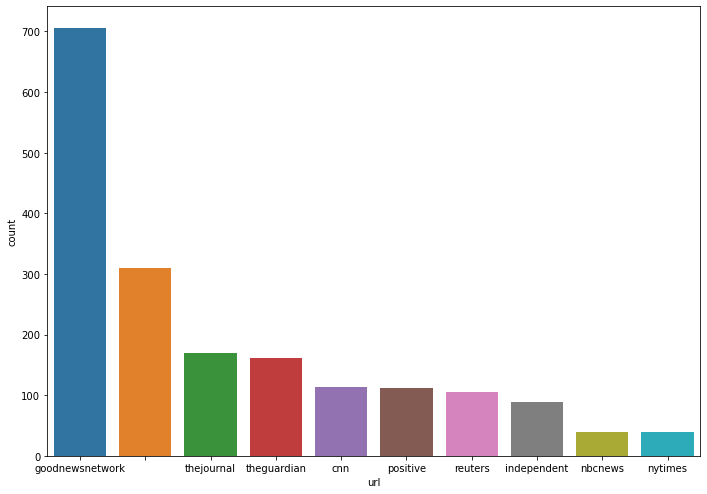

In [8]:
# Show top 10 domains
dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
ax = sns.barplot(x="url", y="count", data=df_url_sorted[0:10])

***
'goodnewsnetwork' is one of the scraped websites for positive news. In contrast to other similar sites, they write all of their articles and don't link to external sources. 
Thus it was expected that they would be one of the most frequent sites to find in our dataset.
'Positive' and 'thejournal' are also scraped sites for positive news, where they write some articles themselves.
***

In [9]:
# Drop specifically scraped sites
df_url_sorted = df_url_sorted.drop(df_url_sorted[df_url_sorted.url == 'goodnewsnetwork'].index)
df_url_sorted = df_url_sorted.drop(df_url_sorted[df_url_sorted.url == 'positive'].index)
df_url_sorted = df_url_sorted.drop(df_url_sorted[df_url_sorted.url == 'thejournal'].index)

The top 10 domains contribute at least 964 articles to the dataset


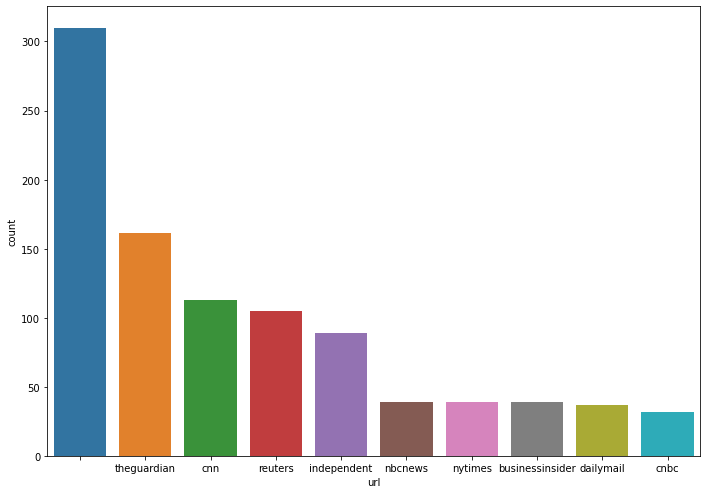

In [10]:
# Show top 10 again
dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
ax = sns.barplot(x="url", y="count", data=df_url_sorted[0:10])
print(f'The top 10 domains contribute at least {df_url_sorted["count"][0:10].sum()} articles to the dataset')

***
These kind of distributions can always influence our machine learning models, as the domains all differ in writing style and website design. Let's keep this in mind for further analysis and later on.
***

***
#### Word influence on good and bad/neutral news
Next up we will analyse the word distribution.
***

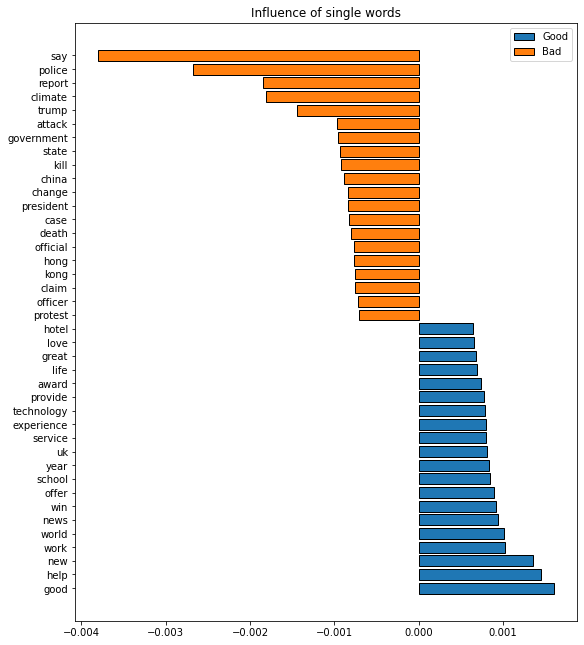

In [11]:
# Import libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize words by their number of appearance
vect = CountVectorizer()
X = vect.fit_transform(df.text_lem)
words = vect.get_feature_names()

# Define label
y = df['label'].values

# Remove alpha to prevent bias
clf = MultinomialNB(alpha=1.e-10)
clf.fit(X,y)

# Create Dataframe for probability
likelihood_df = pd.DataFrame(clf.feature_log_prob_.transpose(),columns=['negative', 'positive'], index=words)
likelihood_df['Influence'] = likelihood_df.eval('(exp(positive) - exp(negative))')
top_10 = likelihood_df['Influence'].sort_values(ascending=False)[:20]

# Double-sorting here so that the graph will look nicer
bottom_10 = likelihood_df['Influence'].sort_values()[:20].sort_values(ascending=False)
top_and_bottom = pd.concat([top_10,bottom_10])

# Plot
x = range(10)
fig = plt.figure(figsize=(9,11))
ax = plt.subplot(111)
ax.barh(top_10.index, top_10, edgecolor='black')
ax.barh(bottom_10.index, bottom_10, edgecolor='black');
ax.set_title('Influence of single words');
ax.legend(['Good', 'Bad']);

***
The influence of bad/neutral words seems to be greater than that of good words. Also the word 'say' seems to appear a lot more in bad/neutral labeled articles than in good ones, which is kind of interesting.
Most of the words make quite a bit of sense. 
'com' in the good category 

***

## Models

In [12]:
# Importing the auxiliary and preprocessing libraries 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Import Models
import warnings
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [13]:
# Create pipeline models
clfs = []
random_state = 69

clfs.append(("LogReg", 
             Pipeline([('tfidf',TfidfVectorizer()),
                       ("LogReg", LogisticRegression(n_jobs=-1, random_state=random_state))], verbose=False)))

clfs.append(("NaiveBayes",
             Pipeline([('tfidf',TfidfVectorizer()),
                       ('naive_bayes', MultinomialNB())], verbose=False)))

clfs.append(("XGBClassifier",
             Pipeline([('tfidf',TfidfVectorizer()),
                       ("XGB", XGBClassifier(n_jobs=-1, random_state=random_state))], verbose=False))) 

clfs.append(("DecisionTreeClassifier", 
             Pipeline([('tfidf',TfidfVectorizer()),
                       ("DecisionTrees", DecisionTreeClassifier(random_state=random_state))], verbose=False))) 

clfs.append(("RandomForestClassifier", 
             Pipeline([('tfidf',TfidfVectorizer()),
                       ("RandomForest", RandomForestClassifier(n_jobs=-1, random_state=random_state))], verbose=False)))

clfs.append(("GradientBoostingClassifier", 
             Pipeline([('tfidf',TfidfVectorizer()),
                       ("GradientBoosting", GradientBoostingClassifier(random_state=random_state))], verbose=False))) 
clfs.append(("RidgeClassifier", 
             Pipeline([('tfidf',TfidfVectorizer()),
                       ("RidgeClassifier", RidgeClassifier(random_state=random_state))], verbose=False)))

clfs.append(("BaggingRidgeClassifier",
             Pipeline([('tfidf',TfidfVectorizer()),
                       ("BaggingClassifier", BaggingClassifier(n_jobs=-1, random_state=random_state))], verbose=False)))

clfs.append(("ExtraTreesClassifier",
             Pipeline([('tfidf',TfidfVectorizer()),
                       ("ExtraTrees", ExtraTreesClassifier(n_jobs=-1, random_state=random_state))], verbose=False)))

clfs.append(("LinearSVC",
             Pipeline([('tfidf',TfidfVectorizer()),
                       ("SupportVector", LinearSVC(random_state=random_state))], verbose=False)))

In [14]:
# Train test val split
X = df['text_lem']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.15, random_state=random_state)

In [15]:
print(f'Shape train: {X_train.shape[0]} rows')
print(f'Shape test: {X_test.shape[0]} rows')
print(f'Shape val: {X_val.shape[0]} rows')

Shape train: 3638 rows
Shape test: 1427 rows
Shape val: 642 rows


In [16]:
# Run the pipelines and save the results
scoring = 'accuracy'
n_folds = 5

results, names, combined  = [], [], {} 

for name, model  in clfs:
    kfold = KFold(n_splits=n_folds, random_state=random_state)
    cv_results = cross_val_score(model, X_train, y_train, 
                                 cv= n_folds, scoring=scoring,
                                 n_jobs=-1)    
    names.append(name)
    results.append(cv_results) 
    combined[name] = cv_results.mean()
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)

LogReg: 0.853491 (+/- 0.011516)
NaiveBayes: 0.834800 (+/- 0.008570)
XGBClassifier: 0.822975 (+/- 0.013890)
DecisionTreeClassifier: 0.691591 (+/- 0.011945)
RandomForestClassifier: 0.838371 (+/- 0.005448)
GradientBoostingClassifier: 0.825449 (+/- 0.007061)
RidgeClassifier: 0.855141 (+/- 0.011812)
BaggingRidgeClassifier: 0.761950 (+/- 0.016489)
ExtraTreesClassifier: 0.848267 (+/- 0.008387)
LinearSVC: 0.851843 (+/- 0.010545)


### Optimization

Let's use the top 5 models and try to tune their parameters for optimal performance

In [17]:
# Sort the results to find the 5 best models
{k: v for k, v in sorted(combined.items(), key=lambda item: item[1], reverse=True)}

{'RidgeClassifier': 0.8551408014269087,
 'LogReg': 0.8534913161116737,
 'LinearSVC': 0.8518425865743611,
 'ExtraTreesClassifier': 0.8482673791133213,
 'RandomForestClassifier': 0.8383712229998338,
 'NaiveBayes': 0.8347997944284051,
 'GradientBoostingClassifier': 0.8254493099747571,
 'XGBClassifier': 0.8229752709463851,
 'BaggingRidgeClassifier': 0.7619499826171079,
 'DecisionTreeClassifier': 0.691590836948471}

***
SVC, Ridge, LogReg, ExtraTrees and RandomForest usually give the best scores. Instead of the RandomForest, we will use the NaiveBayes to bring another sort of algorithm into our VotingClassifier in the end.
***

In [18]:
# Vectorize the data as seen in the pipeline
tfidf = TfidfVectorizer()

tfidf_fit = tfidf.fit(X_train)

X_train_tfidf = tfidf_fit.transform(X_train)
X_test_tfidf = tfidf_fit.transform(X_test)
X_val_tfidf = tfidf_fit.transform(X_val)

import pickle
pickle.dump(tfidf, open("tfidf.pickle", "wb"))

In [19]:
# Function to print the best parameters from Grid- or RandomizedSearch
def best_parameters(model_name):
    print('---------------')
    print('Best parameters')
    print('---------------')
    for pair in model_name.best_params_.items():
        print(f'{pair[0].capitalize()} : {pair[1]}')

#### RidgeClassifier

A RidgeClassifier can only be optimized by chaning its solving algorithm. In this case the 'auto' function already chose the best possible solver for our case, so further tuning is not needed.

In [20]:
# Use the model the test and validation sets
rc = RidgeClassifier(random_state=random_state).fit(X_train_tfidf, y_train)
print(f"Mean Accuracy for train set : {(cross_val_score(rc, X_train_tfidf, y_train).mean()*100).round(2)}%")
print(f"Accuracy for test set : {(rc.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(rc.score(X_val_tfidf, y_val)*100).round(2)}%")

Mean Accuracy for train set : 85.27%
Accuracy for test set : 85.35%
Accuracy for val set: 87.69%


#### Logistic Regression

The default algorithm is already quite good. We can take a look at what happens when we introduce a few different C-Scores.

In [21]:
lr = LogisticRegression(n_jobs=-1, random_state=random_state).fit(X_train_tfidf, y_train)
print(f"Cross validation accuray for train set : {(cross_val_score(lr, X_train_tfidf, y_train).mean()*100).round(2)}%")
print(f"Accuracy for train set : {(lr.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(lr.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(lr.score(X_val_tfidf, y_val)*100).round(2)}%")

Cross validation accuray for train set : 84.83%
Accuracy for train set : 93.46%
Accuracy for test set : 85.35%
Accuracy for val set: 87.85%


In [22]:
# Define parameters for GridSearch
params_lr = {'C' : [0.01, 0.025, 0.05, 0.1, 0.5, 1],
             'solver' : ['saga', 'sag', 'lbfgs']
            }

# Run GridSearchs
lr_search = GridSearchCV(lr, params_lr, cv=5, n_jobs=-1, verbose=1)
lr_search.fit(X_train_tfidf, y_train)

# Print the best parameters
best_parameters(lr_search)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    8.0s finished


---------------
Best parameters
---------------
C : 1
Solver : saga


***
C = 1 is the default value. We will therefore see no change in the outcome. Since the algorithm is not yet overfitting we can leave it at that.
Let's use the 2 params and prove our hypothesis.
***

In [23]:
# Get best model
lr_best = lr_search.best_estimator_

# Fit on the data
lr_best.fit(X_train_tfidf, y_train)

# Print results
print(f"Cross validation for train set : {(cross_val_score(lr_best, X_train_tfidf, y_train).mean()*100).round(2)}%")
print(f"Accuracy for train set : {(lr_best.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(lr_best.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(lr_best.score(X_val_tfidf, y_val)*100).round(2)}%")

Cross validation for train set : 84.88%
Accuracy for train set : 93.51%
Accuracy for test set : 85.42%
Accuracy for val set: 87.38%


#### Extra-trees classifier

In [24]:
# Define model and fit
et = ExtraTreesClassifier(n_jobs=-1, random_state=random_state).fit(X_train_tfidf, y_train)

# Print results
print(f"Cross validation accuray for train set : {(cross_val_score(et, X_train_tfidf, y_train).mean()*100).round(2)}%")
print(f"Accuracy for train set : {(et.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(et.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(et.score(X_val_tfidf, y_val)*100).round(2)}%")

Cross validation accuray for train set : 84.55%
Accuracy for train set : 99.81%
Accuracy for test set : 84.3%
Accuracy for val set: 84.11%


***
The Classifier is overfitting with nearly 100% on the trainset. We will need to tune it down.
***

In [25]:
# Define parameters for RandomizedSearch
params_et = {'max_depth' : np.linspace(10, 110, num = 11).tolist() + [None],
            'min_samples_split' : [5, 10, 15],
            'min_samples_leaf' : [10,15,20],
            'bootstrap' : [True, False],
            'max_leaf_nodes' : [50,100],
            'criterion' : ['gini', 'entropy']
            }

# Run GridSearch
et_search = RandomizedSearchCV(et, params_et, cv=5, n_jobs=-1, verbose=1, n_iter = 100)
et_search.fit(X_train_tfidf, y_train)

# Print the best parameters
best_parameters(et_search)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.0min finished


---------------
Best parameters
---------------
Min_samples_split : 15
Min_samples_leaf : 10
Max_leaf_nodes : 100
Max_depth : 90.0
Criterion : entropy
Bootstrap : False


In [26]:
# Get best model
et_best = et_search.best_estimator_

# Fit on the data
et_best.fit(X_train_tfidf, y_train)

# Print results
print(f"Cross validation for train set : {(cross_val_score(et_best, X_train_tfidf, y_train).mean()*100).round(2)}%")
print(f"Accuracy for train set : {(et_best.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(et_best.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(et_best.score(X_val_tfidf, y_val)*100).round(2)}%")

Cross validation for train set : 83.42%
Accuracy for train set : 88.43%
Accuracy for test set : 83.11%
Accuracy for val set: 82.09%


***
Looking good. Let's see if we can make it even better.
***

In [ ]:
# Define parameters for GridSearch
params_et = {'max_depth' : [45,50,55],
            'min_samples_split' : [5,10,15],
            'min_samples_leaf' : [5,10,15],
            'max_leaf_nodes' : [100,102,104],
            'criterion' : ['entropy']
            }

# Run GridSearch
et_search = GridSearchCV(et, params_et, cv=5, n_jobs=-1, verbose=1)
et_search.fit(X_train_tfidf, y_train)

# Print the best parameters
best_parameters(et_search)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min


In [ ]:
# Get best model
et_best = et_search.best_estimator_

# Fit on the data
et_best.fit(X_train_tfidf, y_train)

# Print results
print(f"Cross validation for train set : {(cross_val_score(et_best, X_train_tfidf, y_train).mean()*100).round(2)}%")
print(f"Accuracy for train set : {(et_best.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(et_best.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(et_best.score(X_val_tfidf, y_val)*100).round(2)}%")

***
It became a tiny bit better. Let's stop here so it doesn't overfit.
***

#### NaiveBayes

In [ ]:
# Define model and fit
nb = MultinomialNB().fit(X_train_tfidf, y_train)

# Print results
print(f"Cross validation accuray for train set : {(cross_val_score(nb, X_train_tfidf, y_train).mean()*100).round(2)}%")
print(f"Accuracy for train set : {(nb.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(nb.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(nb.score(X_val_tfidf, y_val)*100).round(2)}%")

#### Linear SupportVectorClassifier

In [ ]:
# Define model and fit
sv = LinearSVC(random_state=random_state).fit(X_train_tfidf, y_train)

# Print results
print(f"Cross validation accuray for train set : {(cross_val_score(nb, X_train_tfidf, y_train).mean()*100).round(2)}%")
print(f"Accuracy for train set : {(nb.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(nb.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(nb.score(X_val_tfidf, y_val)*100).round(2)}%")

#### Voting Classifier

In [ ]:
vc = VotingClassifier(estimators=[('sv', sv), ('rc', rc), ('lr', lr_best), ('et', et_best), ('nb', nb)], voting='hard')
vc.fit(X_train_tfidf, y_train)

In [ ]:
print(f"Cross validation accuray for train set : {(cross_val_score(vc, X_train_tfidf, y_train).mean()*100).round(2)}%")
print(f"Accuracy for train set : {(vc.score(X_train_tfidf, y_train)*100).round(2)}%")
print(f"Accuracy for test set : {(vc.score(X_test_tfidf, y_test)*100).round(2)}%")
print(f"Accuracy for val set: {(vc.score(X_val_tfidf, y_val)*100).round(2)}%")

In [ ]:
y_pred = vc.predict(X_test_tfidf)

In [ ]:
print(confusion_matrix(y_test, y_pred))

In [ ]:
pickle.dump(vc, open("vc.pickle", "wb"))

In [ ]:
#class Sentiment_Analysis(text_input):
#    def __init__(self):
#        self.binary = 0
#        self.result = 'Neutral/Bad'
#    
#    # VotingClassifier that predicts the Sentiment 0 or 1
#    def classify(self, text_input):
#        self.binary = vc.predict(input)
#    
#    # Transform binary answer to string
#    def good_bad(self):
#        if self.binary == 0
#            return self.result
#        else:
#            self.result = 'Good'       